# 第3章 リサンプリング

## 3.1  クロスバリデーション

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn

/home/yuma/.cache/pypoetry/virtualenvs/statistical-learning-with-python-gf79ENdJ-py3.6/lib/python3.6/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
def cv_linear(X, y, K):
    n = len(y)
    m = int(n / K)
    S = 0
    for j in range(K):
        test = list(range(j * m, (j + 1) * m))  # テストデータの添え字
        train = list(set(range(n)) - set(test))  # 訓練データの添え字
        beta = np.linalg.inv(
            X[train, ].T @ X[train, ]) @ X[train, ].T @ y[train]
        e = y[test] - X[test, ] @ beta
        S = S + np.linalg.norm(e)**2
    return S / n

In [3]:
n = 100
p = 5
X = randn(n, p)
X = np.insert(X, 0, 1, axis=1)

In [4]:
beta = randn(p + 1)
beta[[1, 2]] = 0
y = X @ beta + randn(n)

In [5]:
cv_linear(X[:, [0, 3, 4, 5]], y, 10)

1.365759856903071

In [6]:
cv_linear(X, y, 10)

1.3960521961516266

In [7]:
n = 100
p = 5
X = randn(n, p)
X = np.insert(X, 0, 1, axis=1)
beta = randn(p + 1)
beta[[1, 2]] = 0

In [8]:
U = []
V = []
for j in range(100):
    y = X @ beta + randn(n)
    U.append(cv_linear(X[:, [0, 3, 4, 5]], y, 10))
    V.append(cv_linear(X, y, 10))

Text(0.5, 1.0, ' 変数を多く選びすぎて過学習')

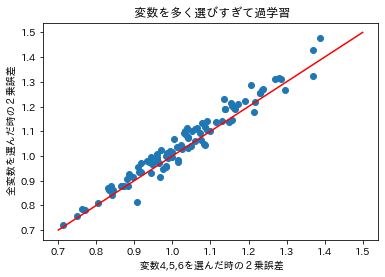

In [9]:
x_seq = np.linspace(0.7, 1.5, 100)
y = x_seq
plt.plot(x_seq, y, c="red")
plt.scatter(U, V)
plt.xlabel(" 変数4,5,6を選んだ時の２乗誤差")
plt.ylabel(" 全変数を選んだ時の２乗誤差")
plt.title(" 変数を多く選びすぎて過学習")

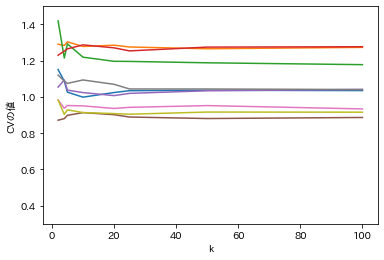

In [10]:
n = 100
p = 5
plt.ylim(0.3, 1.5)
plt.xlabel("k")
plt.ylabel("CVの値")
for j in range(2, 11, 1):
    X = randn(n, p)
    X = np.insert(X, 0, 1, axis=1)
    beta = randn(p + 1)
    y = X @ beta + randn(n)
    U = []
    V = []
    for k in range(2, n + 1, 1):
        if n % k == 0:
            U.append(k)
            V.append(cv_linear(X, y, k))
    plt.plot(U, V)

In [11]:
def knn_1(x, y, z, k):  # 再掲
    x = np.array(x)
    n, p = x.shape
    dis = np.zeros(n)
    for i in range(n):
        dis[i] = (z - x[i, ]).T @ (z - x[i, ])
    S = np.argsort(dis)[0:k]  # 距離が近いk個のindex
    u = np.bincount(y[S])  # 度数を数える
    m = [i for i, x in enumerate(u) if x == max(u)]  # 最頻値のindex
    # タイブレーキングの処理(最頻値が２個以上ある場合)
    while (len(m) > 1):
        k = k - 1
        S = S[0:k]
        u = np.bincount(y[S])
        m = [i for i, x in enumerate(u) if x == max(u)]  # 最頻値のindex
    return m[0]


def knn(x, y, z, k):
    n = z.shape[0]
    w = np.zeros(n)
    for i in range(n):
        w[i] = knn_1(x, y, z[i, ], k)
    return w

In [12]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.target_names
x = iris.data
y = iris.target

In [13]:
n = x.shape[0]
index = np.random.choice(n, n, replace=False)  # 並び替える
x = x[index, ]
y = y[index]

Text(0.5, 1.0, 'CV による誤り率の評価')

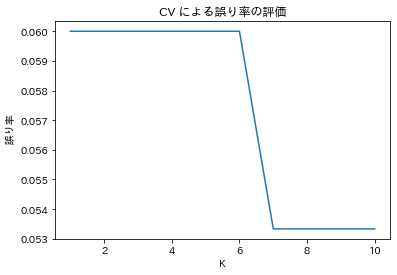

In [14]:
U = []
V = []
top_seq = list(range(0, 135, 10))
for k in range(1, 11, 1):
    S = 0
    for top in top_seq:
        test = list(range(top, top + 15))
        train = list(set(range(150)) - set(test))
        knn_ans = knn(x[train, ], y[train], x[test, ], k=k)
        ans = y[test]
        S = S + np.sum(knn_ans != ans)
    S = S / n
    U.append(k)
    V.append(S)
plt.plot(U, V)
plt.xlabel("K")
plt.ylabel(" 誤り率")
plt.title("CV による誤り率の評価")

↑データによって結構かわります

## 3.2 CV fast

In [15]:
def cv_fast(X, y, k):
    n = len(y)
    m = n / k
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    I = np.diag(np.repeat(1, n))
    e = (I - H) @ y
    I = np.diag(np.repeat(1, m))
    S = 0
    for j in range(k):
        test = np.arange(j * m, (j + 1) * m, 1, dtype=int)
        S = S + (np.linalg.inv(I - H[test, test])
                 @ e[test]).T @ np.linalg.inv(I - H[test, test]) @ e[test]
    return S / n

In [16]:
cv_fast(x, y, 10)

0.05232942400352843

In [17]:
n = 1000
p = 5
beta = randn(p + 1)
x = randn(n, p)
X = np.insert(x, 0, 1, axis=1)

In [18]:
y = X @ beta + randn(n)

In [19]:
import time

Text(0.5, 1.0, 'cv_fastとcv_linearの比較')

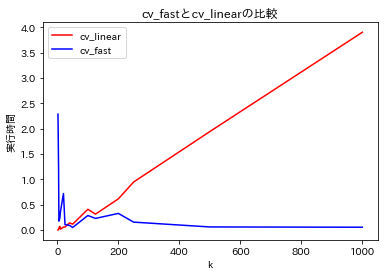

In [20]:
U_l = []
V_l = []
U_f = []
V_f = []
for k in range(2, n + 1, 1):
    if n % k == 0:
        t1 = time.time()  # 処理前の時刻
        cv_linear(X, y, k)
        t2 = time.time()  #処理後の時刻
        U_l.append(k)
        V_l.append(t2 - t1)
        t1 = time.time()
        cv_fast(X, y, k)
        t2 = time.time()
        U_f.append(k)
        V_f.append(t2 - t1)
plt.plot(U_l, V_l, c="red", label="cv_linear")
plt.plot(U_f, V_f, c="blue", label="cv_fast")
plt.legend()
plt.xlabel("k")
plt.ylabel("実行時間")
plt.title("cv_fastとcv_linearの比較")

## 3.3 ブートストラップ

In [21]:
def bt(df, f, r):
    m = df.shape[0]
    org = f(df, np.arange(0, m, 1))
    u = []
    for j in range(r):
        index = np.random.choice(m, m, replace=True)
        u.append(f(df, index))
    return {'original': org, 'bias': np.mean(u) - org, 'stderr': np.std(u)}

In [22]:
Portfolio = np.loadtxt("Portfolio.csv", delimiter=",", skiprows=1)

In [23]:
def func_1(data, index):
    X = data[index, 0]
    Y = data[index, 1]
    return (np.var(Y) - np.var(X)) / (np.var(X) + np.var(Y) -
                                      2 * np.cov(X, Y)[0, 1])

In [24]:
bt(Portfolio, func_1, 1000)

{'original': 0.15330230333295436,
 'bias': 0.008284518099574173,
 'stderr': 0.18338027750130656}

In [25]:
df = np.loadtxt("crime.txt", delimiter="\t")

In [26]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
X = df[:, 2:4]
y = df[:, 0]
reg.fit(X, y)
reg.coef_

array([11.8583308 , -5.97341169])

In [27]:
for j in range(3):

    def func_2(data, index):
        X = data[index, 2:4]
        y = data[index, 0]
        reg.fit(X, y)
        if j == 0:
            return reg.intercept_
        else:
            return reg.coef_[j - 1]

    print(bt(df, func_2, 1000))

{'original': 621.4260363802889, 'bias': 36.990002261832956, 'stderr': 211.95542308252266}
{'original': 11.858330796711092, 'bias': -0.6022690276995171, 'stderr': 3.477101145036724}
{'original': -5.97341168816496, 'bias': -0.28543529333436535, 'stderr': 3.2218203967292243}


In [28]:
import statsmodels.api as sm
n = X.shape[0]
X = np.insert(X, 0, 1, axis=1)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     11.30
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           9.84e-05
Time:                        23:49:02   Log-Likelihood:                -344.79
No. Observations:                  50   AIC:                             695.6
Df Residuals:                      47   BIC:                             701.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        621.4260    222.685      2.791      0.0

In [29]:
n = 1000
p = 5
X = np.insert(randn(n, p), 0, 1, axis=1)
beta = randn(p + 1).reshape(-1, 1)
y = X @ beta + 0.2 * randn(n).reshape(-1, 1)
y = y[:, 0]


## 通常のクロスバリデーションによる方法
def cv_linear(X, y, K):
    n = len(y)
    m = int(n / K)
    S = 0
    for j in range(K):
        test = list(range(j * m, (j + 1) * m))  # テストデータの添え字
        train = list(set(range(n)) - set(test))  # 訓練データの添え字
        beta = np.linalg.inv(
            X[train, ].T @ X[train, ]) @ X[train, ].T @ y[train]
        e = y[test] - X[test, ] @ beta
        S = S + np.linalg.norm(e)**2
    return S / n


## 公式を用いた方法
def cv_fast(X, y, k):
    n = len(y)
    m = n / k
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    I = np.diag(np.repeat(1, n))
    e = (I - H) @ y
    I = np.diag(np.repeat(1, m))
    S = 0
    for j in range(k):
        test = np.arange(j * m, (j + 1) * m, 1, dtype=int)
        S = S + (np.linalg.inv(I - H[test, test])
                 @ e[test]).T @ np.linalg.inv(I - H[test, test]) @ e[test]
    return S / n